# UFO 1 data analysis part 1

Big Data házi feladat, UFO1 feladatkör EDA analízise, adatfelderítése.

A használathoz feltételezzük, hogy már létezik egy állomány, data.csv néven, ami tartalmazza a szükséges adatokat.

Ennek a notebooknak a célja, hogy a letöltött adatokkal megismerkedjünk, néhány megfigyelést állapítsunk meg róluk, esetlegesen a nem megfelelő adatokat kiemeljük, és töröljük a készletből.


## Adatok betöltése, átalakítása

Az egyszerű betöltés után néhány kisebb módosítást végeztünk az adatokon:
* Date / Time osztlop átnevezése Date-re, az kezelhetőbbség kedvéért
* Shape oszlop értékei nem voltak konzisztensen kis vagy nagybetűsek, ezért ezeket egységesen csupa lowercase-re konvertáltuk
* A dátumok feldolgozásához a Python saját parser-ét használtuk
    * Amit az nem volt képes feldolgozni, azt egy nem előforduló értékre állítottuk, amit majd később ki lehet szűrni / el lehet dobni
    * Mivel az eredeti adatok szintaxisa miatt jövőbeni adatokat talált a parser, ezért ezeket kézzel módosítottuk

In [1]:
%matplotlib inline
import pandas
import matplotlib
import time

In [2]:
start = time.time()
raw_data = pandas.read_csv("data.csv", sep=";", encoding="UTF8", header=None, skiprows=1)
data = []
wrong_data = []
skipped_lines = 0
for _, d in raw_data.iterrows():
    try:
        # Transform or validate data
        date = pandas.to_datetime(d[0])
        posted = pandas.to_datetime(d[6])
        
        # Do some checks...
        if date.date() > posted.date():
            wrong_data.append((date, d[1], d[2], d[3], d[4], d[5], posted, d[7]))
            continue
        
        # Add data to cleaned array
        data.append((date, d[1], d[2], d[3], d[4], d[5], posted, d[7]))
    except Exception as e:
        skipped_lines += 1

names = ["Date", "City", "State", "Shape", "Duration", "Summary", "Posted", "Description"]
data = pandas.DataFrame.from_records(data, columns=names)
wrong_data = pandas.DataFrame.from_records(wrong_data, columns=names)

print('Loading data took ' + str(time.time() - start) + 's')
print('Raw data: ' + str(len(raw_data)))
print('Processed data: ' + str(len(data)))
print('Skipped because of parser exception: ' + str(skipped_lines))
print('Wrong data: ' + str(len(wrong_data)))

Loading data took 87.51090335845947s
Raw data: 113241
Processed data: 111418
Skipped because of parser exception: 118
Wrong data: 1705


## Adatok feltérképezése

### Használt oszlopok és az értékek típusai

In [3]:
data

,Date,City,State,Shape,Duration,Summary,Posted,Description
0,2017-11-03 04:15:00,Norwalk,IA,NaN,5 minutes,"I did not see a craft, I took the dog out at 4...",2017-11-03,NaN
1,2017-10-29 20:00:00,UK/England,NaN,NaN,NaN,At approx. 8pm moon was behind clouds and a la...,2017-11-03,NaN
2,2017-10-27 10:00:00,North Gower (Canada),ON,NaN,3 seconds,Star moving in an unusual manner.,2017-11-03,NaN
3,2017-10-24 22:25:00,Northfield,VT,NaN,1-2 seconds,((NUFORC Note: Source of report provides not ...,2017-11-03,NaN
4,2017-10-22 19:06:00,Hope Mills,NC,NaN,9 minutes,Three family members witness Orange light orbs...,2017-11-03,NaN
5,2017-10-20 15:15:00,Scarborough (Canada),ON,NaN,3 minutes,A Very High Slow Shimmering Brilliant White Li...,2017-11-03,NaN
6,2017-10-19 13:17:00,Hollywood,FL,NaN,90 seconds,((NUFORC Note: Witness provides no significan...,2017-11-03,NaN
7,2017-10-17 20:45:00,Bethel,OH,NaN,2 minutes,"4 Orange Glowing Lights, moving, going on and ...",2017-10-19,NaN
8,2017-10-17 14:22:00,Bay Village,OH,NaN,20 minutes,"Strange sounds heard by myself and neighbors, ...",2017-10-19,NaN
9,2017-10-15 08:00:00,Fort Montgomery,NY,NaN,Everyday,((NUFORC Note: Witness provides no significan...,2017-10-19,NaN


### Adatok vizualizációja az észlelés ideje alapján

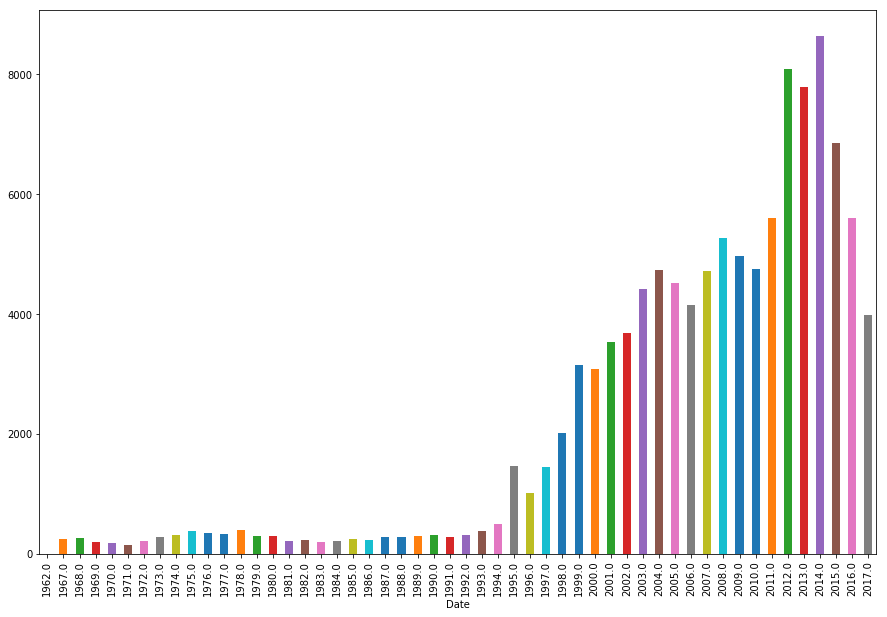

In [4]:
data.groupby(data["Date"].dt.year).count()["Date"].plot(figsize=(15,10),kind="bar")

### Adatok vizualizációja az észlelt ufók száma alapján, alak szerint csoportosítva

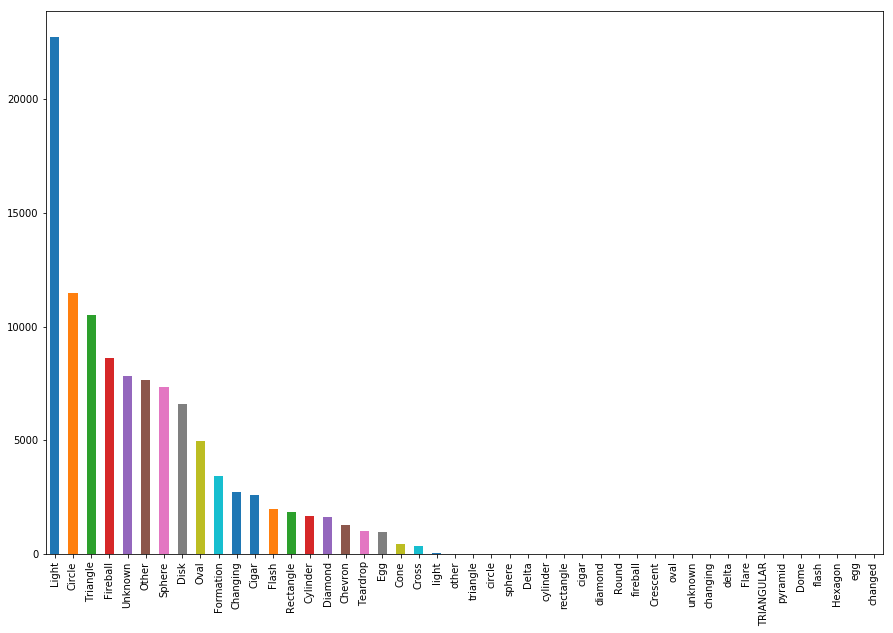

In [5]:
shape_counts = data["Shape"].value_counts()
shape_counts.plot(figsize=(15,10),kind="bar")